In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Gerekli Kütüphaneler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif # Mutual Information
from sklearn.naive_bayes import GaussianNB # Naive Bayes Modeli
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve, 
                             average_precision_score, log_loss, cohen_kappa_score)

warnings.filterwarnings('ignore')

print(">>> NAIVE BAYES + MUTUAL INFORMATION İŞLEMİ BAŞLATILIYOR...\n")




>>> NAIVE BAYES + MUTUAL INFORMATION İŞLEMİ BAŞLATILIYOR...



In [3]:
# ---------------------------------------------------------
# 1. ADIM: VERİ YÜKLEME VE TEMİZLİK
# ---------------------------------------------------------
df = pd.read_csv(r'C:\Users\YIGIT\Desktop\WorkSpace\Okul\US_Crime_DataSet.csv', low_memory=False)

# Leakage Önleme (Fail Bilgilerini Atma)
cols_to_drop = [
    'Record ID', 'Agency Code', 'Incident', 'Record Source',
    'Victim Ethnicity', 'Victim Count',
    'Perpetrator Ethnicity', 'Perpetrator Count',
    'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race', 'Relationship'
]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# Target Dönüşümü (Yes/No -> 1/0)
df['Crime Solved'] = df['Crime Solved'].map({'Yes': 1, 'No': 0})

# Yaş Temizliği
df['Victim Age'] = pd.to_numeric(df['Victim Age'], errors='coerce')
df.loc[(df['Victim Age'] > 99) | (df['Victim Age'] == 0), 'Victim Age'] = np.nan
df['Victim Age'] = df['Victim Age'].fillna(df['Victim Age'].median())

# Encoding (Naive Bayes ve MI sayısal veri ister)
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

print("Veri Temizliği ve Encoding Tamamlandı. Veri Boyutu:", df.shape)

Veri Temizliği ve Encoding Tamamlandı. Veri Boyutu: (638454, 12)



>>> MUTUAL INFORMATION HESAPLANIYOR (Biraz zaman alabilir)...
Seçilen En İyi 10 Özellik: ['Agency Name', 'Agency Type', 'City', 'State', 'Month', 'Crime Type', 'Victim Sex', 'Victim Age', 'Victim Race', 'Weapon']


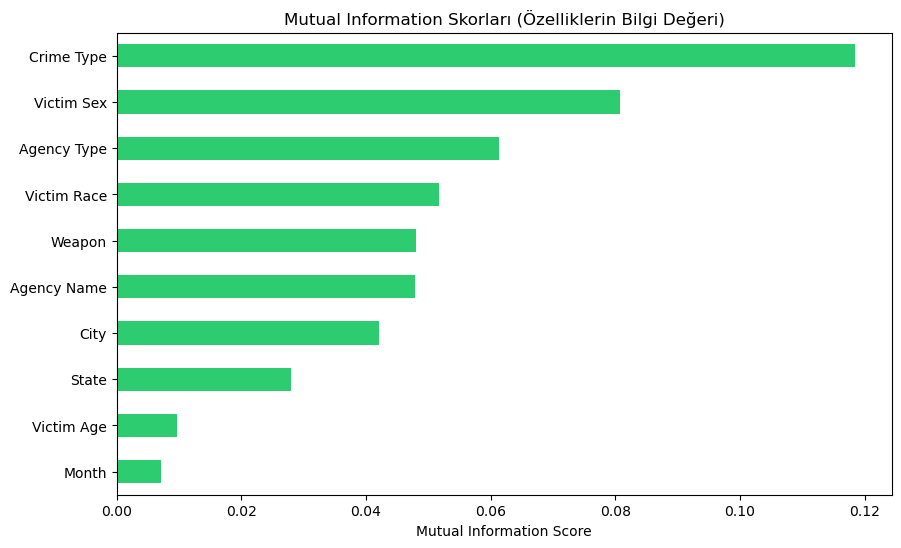

In [4]:
# ---------------------------------------------------------
# 2. ADIM: FEATURE SELECTION - MUTUAL INFORMATION
# ---------------------------------------------------------
print("\n>>> MUTUAL INFORMATION HESAPLANIYOR (Biraz zaman alabilir)...")

X = df.drop('Crime Solved', axis=1)
y = df['Crime Solved']

# SelectKBest: En yüksek Mutual Info skoruna sahip 10 özelliği seç
# mutual_info_classif: Kategorik/Kesikli veriler için uygundur
selector = SelectKBest(score_func=mutual_info_classif, k=10) 
X_new = selector.fit_transform(X, y)

# Seçilen sütunları belirle
mask = selector.get_support()
selected_features = X.columns[mask]
print(f"Seçilen En İyi 10 Özellik: {selected_features.tolist()}")

# Mutual Information Skorlarını Görselleştir
scores = pd.Series(selector.scores_[mask], index=selected_features).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
scores.plot(kind='barh', color='#2ecc71') # Yeşil renk
plt.title("Mutual Information Skorları (Özelliklerin Bilgi Değeri)")
plt.xlabel("Mutual Information Score")
plt.show()

In [5]:
# ---------------------------------------------------------
# 3. ADIM: MODELLEME - NAIVE BAYES (GaussianNB)
# ---------------------------------------------------------
print("\n>>> NAIVE BAYES MODELİ EĞİTİLİYOR...")

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# Gaussian Naive Bayes Başlat
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)
y_pred_proba = nb_model.predict_proba(X_test)[:, 1]

print("Model Eğitimi Tamamlandı.")


>>> NAIVE BAYES MODELİ EĞİTİLİYOR...
Model Eğitimi Tamamlandı.


In [6]:
# ---------------------------------------------------------
# 4. ADIM: KAPSAMLI RAPORLAMA
# ---------------------------------------------------------
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)
kappa = cohen_kappa_score(y_test, y_pred)

print("\n" + "="*50)
print("       MODEL PERFORMANS RAPORU (NAIVE BAYES + MUTUAL INFO)       ")
print("="*50)
print(f"Model: Gaussian Naive Bayes")
print(f"Feature Selection: Mutual Information (Top 10)")
print("-" * 50)
print(f"1. Accuracy (Doğruluk):      {accuracy:.4f}")
print(f"2. ROC AUC Score:            {roc_auc:.4f}")
print(f"3. Cohen's Kappa:            {kappa:.4f}")
print(f"4. Log Loss:                 {logloss:.4f}")
print("-" * 50)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print("="*50)



       MODEL PERFORMANS RAPORU (NAIVE BAYES + MUTUAL INFO)       
Model: Gaussian Naive Bayes
Feature Selection: Mutual Information (Top 10)
--------------------------------------------------
1. Accuracy (Doğruluk):      0.5805
2. ROC AUC Score:            0.6074
3. Cohen's Kappa:            0.1352
4. Log Loss:                 0.6718
--------------------------------------------------

Classification Report:

              precision    recall  f1-score   support

           0       0.37      0.57      0.45     37875
           1       0.76      0.58      0.66     89816

    accuracy                           0.58    127691
   macro avg       0.57      0.58      0.55    127691
weighted avg       0.65      0.58      0.60    127691



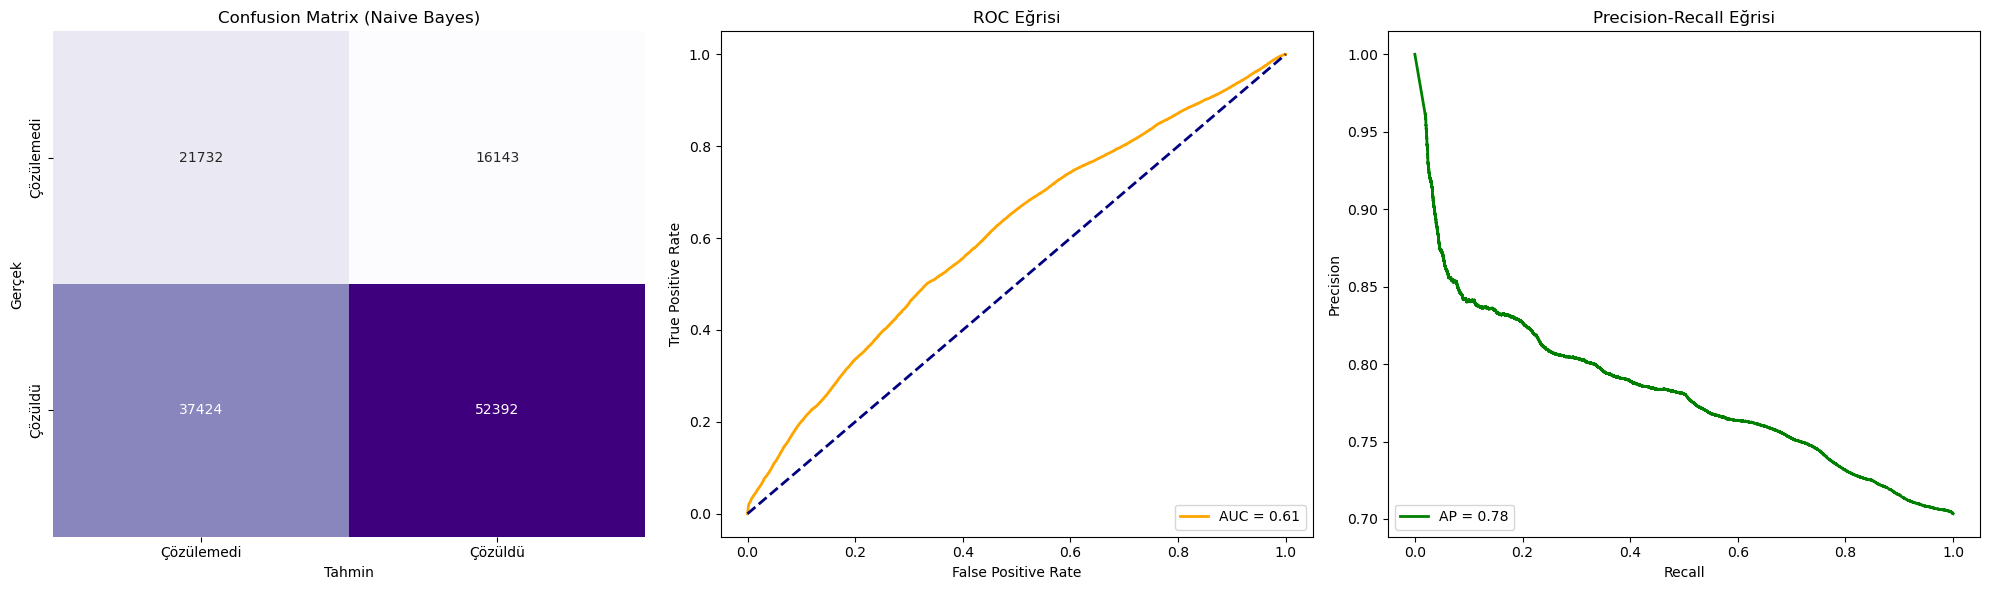

In [8]:
# --- GRAFİKLER ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix (Naive Bayes)')
axes[0].set_xlabel('Tahmin')
axes[0].set_ylabel('Gerçek')
axes[0].set_xticklabels(['Çözülemedi', 'Çözüldü'])
axes[0].set_yticklabels(['Çözülemedi', 'Çözüldü'])

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='orange', lw=2, label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Eğrisi')
axes[1].legend(loc="lower right")

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
axes[2].plot(recall, precision, color='green', lw=2, label=f'AP = {avg_precision:.2f}')
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Eğrisi')
axes[2].legend(loc="lower left")

plt.tight_layout()
plt.show()